In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from moviepy.editor import *
import cv2
import moviepy
import sys
import random
import tensorflow.keras.layers as tfKL
import sklearn
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Activation, Dense 
from sklearn.model_selection import train_test_split
import time
from matplotlib import pyplot as plt
import random
import pickle
import pandas as pd
import gc
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Concatenate, Input, Lambda,LSTM,Reshape
from tensorflow.keras.models import Model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1343488/45929032 bytes (2.9%)3842048/45929032 bytes (8.4%)7462912/45929032 bytes (16.2%)10821632/45929032 bytes (23.6%)14368768/45929032 bytes (31.3%)18079744/45929032 bytes (39.4%)21823488/45929032 bytes (47.5%)25427968/45929032 bytes (55.4%)28950528/45929032 bytes (63.0%)32342016/45929032 bytes (70.4%)35766272/45929032 bytes (77.9%)39165952/45929032 bytes (85.3%)4

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
mainPath="/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND" 

In [ ]:
nCategories=8

In [ ]:
partition ={}
labels ={}
partition['train']=list()
partition['validation']=list()
partition['test']=list()
def mapCatToNumber(file1):
  strings=[]
  for cat in os.listdir(file1):
    strings.append(cat)
  stringsS=sorted(strings)
  answer={}
  for i in range(len(stringsS)):
    answer[stringsS[i]]=i
  return answer
mappingCatToN=mapCatToNumber(mainPath)
print(mappingCatToN)

{'accident': 0, 'call': 1, 'doctor': 2, 'help': 3, 'hot': 4, 'lose': 5, 'pain': 6, 'thief': 7}


In [ ]:
for category in os.listdir(mainPath):
  print(category)
  vidL=[]
  for video in os.listdir(os.path.join(mainPath,category)):
    vidL.append(os.path.join(mainPath,category,video))
  lenVidL=len(vidL)
  trainLen=(int)(3*lenVidL/4)
  testLen=int(lenVidL/10)
  valLen=lenVidL-trainLen-testLen
  print(trainLen," ",valLen," ",testLen)
  random.shuffle(vidL)
  for i in range(lenVidL):
    labels[vidL[i]]=mappingCatToN[category]
    if i<trainLen:
      partition['train'].append(vidL[i])
    elif i<trainLen+valLen:
      partition['validation'].append(vidL[i])
    else:
      partition['test'].append(vidL[i])

accident
39   8   5
call
39   8   5
thief
37   8   5
pain
39   8   5
lose
30   6   4
doctor
39   8   5
hot
39   8   5
help
39   8   5


In [ ]:
print(np.shape(partition['train']))
print(np.shape(partition['validation']))
print(np.shape(partition['test']))

(301,)
(62,)
(39,)


In [ ]:
def prepVids(partition=partition,Tframes=20,frameSize=(80,80)):
  vids={}
  for vid in partition['train']+partition['validation']+partition['test']:
    vids[vid]=np.empty((Tframes,frameSize[0],frameSize[1],3),dtype=int)
    try:
      vidObj = moviepy.editor.VideoFileClip(vid)
    except IOError as e:
      errno, strerror = e.args
      print(errno)
      print(strerror)
    video_duration = int(vidObj.duration)   
    nFrames=Tframes
    array=np.empty(shape=(nFrames,frameSize[0],frameSize[1],3))
    for k in range(nFrames):
      frame=vidObj.get_frame((k+1)*video_duration/(nFrames*1.0))
      frameR=Image.fromarray(frame).convert("RGB")
      frame2=frameR.resize(frameSize)
      array[k]=np.array(frame2)
      del frame,frameR,frame2
    vids[vid]=array
    # vids[vid]=np.reshape(array,(nSubsequences,nLookback,frameSize[0],frameSize[1],3))
    del array
    gc.collect()
  gc.collect()
  return vids

In [ ]:
with tf.device('/device:GPU:0'):
  Tframes=20
  frameSize=(224,224)
  begin=time.time()
  vids=prepVids(frameSize=frameSize,Tframes=Tframes)
  end=time.time()
  print("Time for prep: ",end-begin)

Time for prep:  377.09422636032104


In [ ]:
print(np.shape(vids[("/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/call/00000299.avi")]))

(20, 224, 224, 3)


In [ ]:
gc.collect()

0

In [ ]:
import numpy as np

class DataGenerator(tf.keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, list_IDs, labels, batch_size=32, dim=(20,224,224,3), n_classes=8, shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()
  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
        np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    n1=len(list_IDs_temp)
    X = np.empty((self.batch_size, *self.dim),dtype=int)
    y = np.empty((self.batch_size), dtype=int)
    # X = np.empty((n1, *self.dim),dtype=int)
    # y = np.empty((n1), dtype=int)
    # Generate data
    for i, ID in enumerate(list_IDs_temp):
      # Store sample
      # X[i,] = np.load('data/' + ID + '.npy')
      ######
      # print(ID)
      # try:
      #   vidObj = moviepy.editor.VideoFileClip(ID)
      # except IOError as e:
      #   errno, strerror = e.args
      #   print(errno)
      #   print(strerror)
      # video_duration = int(vidObj.duration)   
      # nFrames=self.dim[0]
      # array=np.empty(shape=(nFrames,self.dim[1],self.dim[2],3))
      # frameSize=(self.dim[1],self.dim[2])
      # for k in range(nFrames):
      #   frame=vidObj.get_frame((k+1)*video_duration/(nFrames*1.0))
      #   frameR=Image.fromarray(frame).convert("RGB")
      #   frame2=frameR.resize(frameSize)
      #   # arrayi=np.array(frame2)/255
      #   # if k is 0:
      #   #   print(np.shape(arrayi))
      #   array[k]=np.array(frame2)
      #   del frame,frameR,frame2
      #   # del arrayi
      # # print(np.shape(array))
      # X[i,]=array
      # del array
      X[i,]=vids[ID]
      #######
      # Store class
      y[i] = self.labels[ID]
    # X=np.reshape(X,(X.shape[0],nSubsequences,nLookback,self.dim[1],self.dim[2],3))
    gc.collect()
    print("Shape of X output by data generator: ",np.shape(X))
    # X=X.astype(np.int32)
    return np.array(X), keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
def getLabels(partition=partition):
  labels={}
  for category in os.listdir(mainPath):
    print(category)
    vidL=[]
    for video in os.listdir(os.path.join(mainPath,category)):
      vidL.append(os.path.join(mainPath,category,video))
      lenVidL=len(vidL)
      random.shuffle(vidL)
      for i in range(lenVidL):
        labels[vidL[i]]=mappingCatToN[category]
  return  labels
labels=getLabels()
print(labels)

accident
call
thief
pain
lose
doctor
hot
help
{'/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000350.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000351.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000352.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000353.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000354.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000355.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000356.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000357.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000358.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000359.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000360.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000361.avi': 0, '/con

In [ ]:
import gc
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
  def on_batch_end(self, epoch, logs=None):
    print("Batch end")
    gc.enable()
    gc.collect()
    return

In [ ]:
def createModel4(Tframes=20,frameSize=(224,224),batch_size=10,epochs=500,verbose=2,metrics=['accuracy'],loss='categorical_crossentropy',optimizer='adam',nLstmUnits=147):
  input=Input(shape=(Tframes,frameSize[0],frameSize[1],3))
  inc=InceptionV3(include_top=False,input_shape=(224,224,3))
  branchOutputs=[]
  for i in range(Tframes):
    out=Lambda(lambda x: x[:,i,:,:,:])(input)
    print("out.shape: ",out.shape)
    name="inception_"+str(i)
    tempModel=Sequential(name=name)
    # tempModel.add(InceptionV3(include_top=False,input_shape=(224,224,3)))
    tempModel.add(inc)
    out1=tempModel(out)
    branchOutputs.append(out1)
  out = Concatenate()(branchOutputs)
  '''
  model=Model(inputs=input,outputs=out)
  model2=Sequential()
  model2.add(model)
  model2.add(tfKL.TimeDistributed(LSTM(units=nLstmUnits,activation='tanh',input_shape=(None,7,7,512))))
  model2.add(tfKL.Flatten())
  model2.add(Dense(units=8,activation='softmax'))
  model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  '''
  out=tfKL.TimeDistributed(LSTM(units=nLstmUnits,activation='tanh',input_shape=(None,7,7,512)))(out)
  out=tfKL.Flatten()(out)
  out=Dense(units=8,activation='softmax')(out)
  model=Model(inputs=input,outputs=out)
  model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
  for layer in model.layers:
    print(layer.name)
  return model

In [ ]:
# del model
gc.collect()

313

out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
input_1
lambda
lambda_1
lambda_2
lambda_3
lambda_4
lambda_5
lambda_6
lambda_7
lambda_8
lambda_9
lambda_10
lambda_11
lambda_12
lambda_13
lambda_14
lambda_15
lambda_16
lambda_17
lambda_18
lambda_19
inception_0
inception_1
inception_2
inception_3
inception_4
inception_5
inception_6
inception_7
inception_8
inception_9
inception_10
inception_11
inception_12
incep

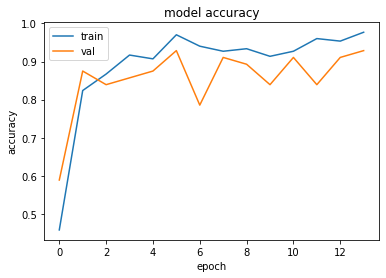

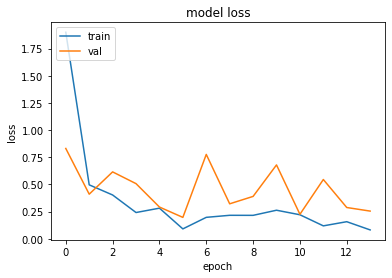

Time taken:  1308.8898124694824


In [ ]:
with tf.device('/device:GPU:0'):
  batch_size=7
  nLstmUnits=1680
  frameSize=(224,224)
  params = {'dim': (Tframes,frameSize[0],frameSize[1],3),
            'batch_size': batch_size,
            'n_classes': 8,
            'shuffle': True}
  epochs=14
  # Generators
  training_generator = DataGenerator(partition['train'], labels, **params)
  validation_generator = DataGenerator(partition['validation'], labels, **params)


  model=createModel4(Tframes=Tframes,nLstmUnits=nLstmUnits,optimizer=keras.optimizers.Adam(learning_rate=0.00038))
  begin=time.time()
  history=model.fit_generator(epochs=epochs,verbose=2,generator=training_generator,
                    validation_data=validation_generator,callbacks=[LossAndErrorPrintingCallback()])
  end=time.time()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  print("Time taken: ",end-begin)

In [ ]:
with tf.device('/device:GPU:0'):
  epochs=1
  begin=time.time()
  history1=model.fit_generator(epochs=epochs,verbose=2,generator=training_generator,
                    validation_data=validation_generator,callbacks=[LossAndErrorPrintingCallback()])
  end=time.time()

Shape of X output by data generator:  (7, 20, 224, 224, 3)
Shape of X output by data generator:  (7, 20, 224, 224, 3)
Shape of X output by data generator:  (7, 20, 224, 224, 3)
Batch end
Shape of X output by data generator:  (7, 20, 224, 224, 3)
Batch end
Shape of X output by data generator:  (7, 20, 224, 224, 3)
Batch end
Shape of X output by data generator:  (7, 20, 224, 224, 3)
Batch end
Shape of X output by data generator:  (7, 20, 224, 224, 3)
Batch end
Shape of X output by data generator:  (7, 20, 224, 224, 3)
Batch end
Shape of X output by data generator:  (7, 20, 224, 224, 3)
Batch end
Shape of X output by data generator:  (7, 20, 224, 224, 3)
Batch end
Shape of X output by data generator:  (7, 20, 224, 224, 3)
Batch end
Shape of X output by data generator:  (7, 20, 224, 224, 3)
Batch end
Shape of X output by data generator:  (7, 20, 224, 224, 3)
Batch end
Shape of X output by data generator:  (7, 20, 224, 224, 3)
Batch end
Shape of X output by data generator:  (7, 20, 224, 224

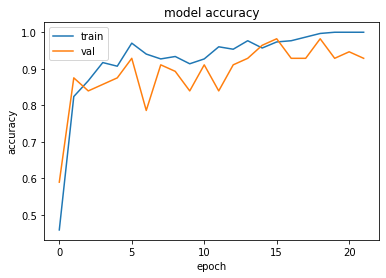

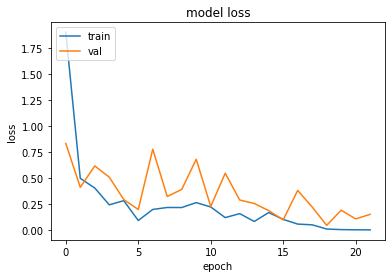

Time taken:  95.06382727622986


In [ ]:
for keyw in ['loss','val_loss','accuracy','val_accuracy']:
  history.history[keyw]=history.history[keyw]+history1.history[keyw]

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print("Time taken: ",end-begin)

In [ ]:
def testAccuracy(Result,testSetY):
  diff=np.asarray(Result)-np.asarray(testSetY)
  answer=(((np.shape(diff))[0]-np.count_nonzero(diff)))/(np.shape(diff)[0])
  return answer

In [ ]:
with tf.device('/device:GPU:0'):
  params1 = params
  params1['shuffle']=False
  params1['batch_size']=1
  testing_generator = DataGenerator(partition['test'], labels, **params1)
  res=model.predict_generator(testing_generator,callbacks=LossAndErrorPrintingCallback())

Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 

In [ ]:
res2=np.argmax(res,axis=1)
print("Our prediction: ")
print(res2)
testY=[]
for el in partition['test']:
  testY.append(labels[el])
print("Truth: ")
print(testY)

Our prediction: 
[0 0 0 0 0 1 1 1 1 1 7 7 7 7 7 6 6 6 6 6 5 5 5 5 2 2 2 2 2 4 4 4 4 4 3 3 3
 3 3]
Truth: 
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3]


In [ ]:
print(testAccuracy(res2,testY))

1.0


In [ ]:
gc.collect()

150

In [ ]:
# with tf.device('/device:GPU:0'):
#   model.save("/content/gdrive/MyDrive/bbgInception.h5")

In [ ]:
# with tf.device("/device:GPU:0"):
#   modelL=tf.keras.models.load_model("/content/gdrive/MyDrive/bbgInception.h5")
#   modelL.summary()
#   # del modelL
#   gc.collect()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 224, 224 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
gc.collect()

99

In [ ]:
with tf.device('/device:GPU:0'):
  frameSize=(224,224)
  params = {'dim': (Tframes,frameSize[0],frameSize[1],3),
            'batch_size': 1,
            'n_classes': 8,
            'shuffle': True}
  params1 = params
  params1['shuffle']=False
  params1['batch_size']=1
  testing_generator = DataGenerator(partition['train']+partition['validation']+partition['test'], labels, **params1)
  begin=time.time()
  res=modelL.predict_generator(testing_generator,callbacks=LossAndErrorPrintingCallback())
  end=time.time()
  print(end-begin)

Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 3)
Shape of X output by data generator:  (1, 20, 224, 224, 

In [ ]:
with tf.device("/device:GPU:0"):
  res2=np.argmax(res,axis=1)
  print("Our prediction: ")
  print(res2)
  testY=[]
  for el in partition['train']+partition['validation']+partition['test']:
    testY.append(labels[el])
  print("Truth: ")
  print(testY)

Our prediction: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 6 6 6 6 6 6
 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 2 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6
 5 5 5 5 5 5 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 0 0 0 0 0 1 1
 1 1 1 7 7 7 7 7 6 6 6 6 6 5 5 5 5 2 2 2 2 2 4 4 4 4 4 3 3 3 3 3]
Truth: 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
print(testAccuracy(res2,testY))

0.9900497512437811


In [ ]:
def mapNumberToCat(file1):
  strings=[]
  for cat in os.listdir(file1):
    strings.append(cat)
  stringsS=sorted(strings)
  answer={}
  for i in range(len(stringsS)):
    answer[i]=stringsS[i]
  return answer
mapNToCat=mapNumberToCat(mainPath)
print(mapNToCat)

{0: 'accident', 1: 'call', 2: 'doctor', 3: 'help', 4: 'hot', 5: 'lose', 6: 'pain', 7: 'thief'}


In [ ]:
textResult=[mapNToCat[x] for x in res2]

In [ ]:
print(textResult)

['accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'accident', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'hot', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thief', 'thi